# 4章 GLMのモデル選択
\

### ライブラリのインポート

In [47]:
import polars as pl
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

from scipy.stats import poisson

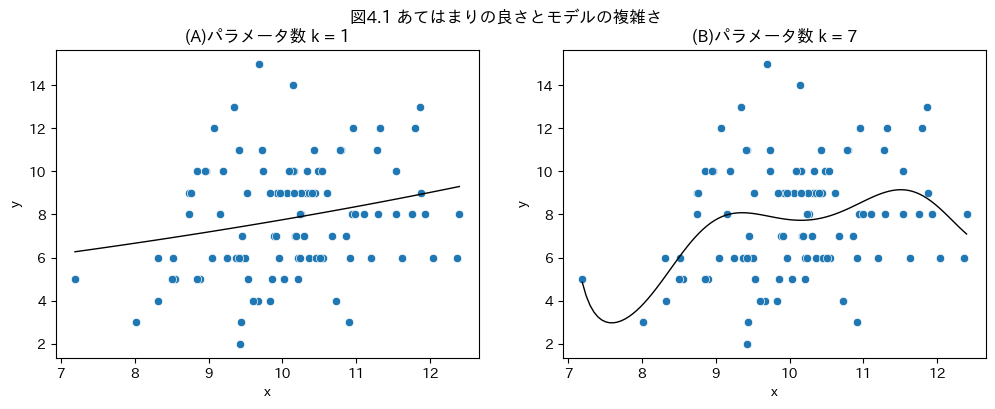

In [39]:
# あてはまりの良さとモデルの複雑さを可視化する

# データを読み込む
# 他のライブラリとの連携はpandasの方が上なので、pandasに変換する.
d = pl.read_parquet("../data/ch 03/data3a.parquet").to_pandas()

# 一般化線形モデル
# パラメータ数 k = 1
form_k1 = "y ~ x"
model_k1 = smf.glm(formula = form_k1, data = d, family = sm.families.Poisson()).fit()
# パラメータ数 k = 7
form_k7 = "y ~ x + np.power(x, 2) + np.power(x, 3) + np.power(x, 4)+ np.power(x, 5)+ np.power(x, 6)"
model_k7 = smf.glm(formula = form_k7, data = d, family = sm.families.Poisson()).fit()

# 可視化
fig, axes = plt.subplots(1, 2, figsize = (12, 4))
# 生データ
sns.scatterplot(data = d, x = "x", y = "y", ax = axes[0])
sns.scatterplot(data = d, x = "x", y = "y", ax = axes[1])
# モデルの予測値
xx = pl.DataFrame({"x": np.linspace(d["x"].min(), d["x"].max(), 100)}).to_pandas()
sns.lineplot(x = xx["x"], y = model_k1.predict(xx), color = "black", linewidth = 1, ax = axes[0])
sns.lineplot(x = xx["x"], y = model_k7.predict(xx), color = "black", linewidth = 1, ax = axes[1])

plt.suptitle("図4.1 あてはまりの良さとモデルの複雑さ")
axes[0].title.set_text('(A)パラメータ数 k = 1')
axes[1].title.set_text('(B)パラメータ数 k = 7')

## 4.1 データはたくさん,モデルはたくさん

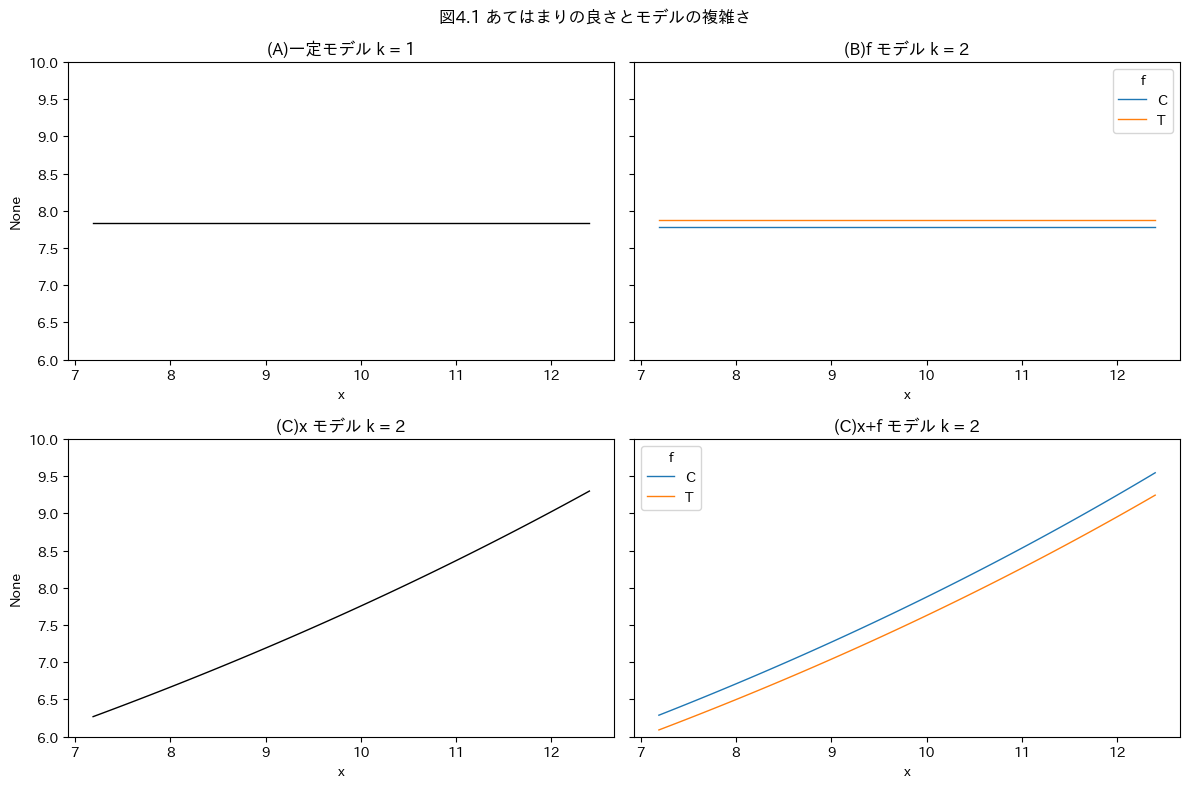

In [42]:
# あてはまりの良さとモデルの複雑さを可視化する

# 一般化線形モデル
# (A)一定モデル k = 1
form_A = "y ~ 0 + np.power(x, 0)"
model_A = smf.glm(formula = form_A, data = d, family = sm.families.Poisson()).fit()
# (B)fモデル k = 2
form_B = "y ~ f"
model_B = smf.glm(formula = form_B, data = d, family = sm.families.Poisson()).fit()
# (C)xモデル k = 2
form_C = "y ~ x"
model_C = smf.glm(formula = form_C, data = d, family = sm.families.Poisson()).fit()
# (D)xv+ fモデル k = 3
form_D = "y ~ x + f"
model_D = smf.glm(formula = form_D, data = d, family = sm.families.Poisson()).fit()


# 可視化
fig, axes = plt.subplots(2, 2, figsize = (12, 8), sharey = "all")
# モデルの予測値
xx = pl.DataFrame({"x": np.linspace(d["x"].min(), d["x"].max(), 100)}).to_pandas()
xf = pl.concat([
    pl.DataFrame({ "x": np.linspace(d["x"].min(), d["x"].max(), 100), "f": ["C"] * 100}),
    pl.DataFrame({ "x": np.linspace(d["x"].min(), d["x"].max(), 100), "f": ["T"] * 100 })
]).to_pandas()
sns.lineplot(x = xx["x"], y = model_A.predict(xx), color = "black", linewidth = 1, ax = axes[0, 0])
sns.lineplot(x = xf["x"], y = model_B.predict(xf), color = "black", hue = xf["f"], linewidth = 1, ax = axes[0, 1])
sns.lineplot(x = xx["x"], y = model_C.predict(xx), color = "black", linewidth = 1, ax = axes[1, 0])
sns.lineplot(x = xf["x"], y = model_D.predict(xf), color = "black", hue = xf["f"], linewidth = 1, ax = axes[1, 1])

plt.suptitle("図4.1 あてはまりの良さとモデルの複雑さ")
axes[0, 0].title.set_text('(A)一定モデル k = 1')
axes[0, 1].title.set_text('(B)f モデル k = 2')
axes[1, 0].title.set_text('(C)x モデル k = 2')
axes[1, 1].title.set_text('(C)x+f モデル k = 2')

axes[0, 0].set_ylim(6, 10)
plt.tight_layout()

## 4.2 統計モデルのあてはまりの悪さ: 逸脱度

表4.1 この節に登場する様々な逸脱度

| 名前 | 定義 |
| ---- | ---- |
| 逸脱度($D$) | $-2 \log L$ |
| 最小の逸脱度 | フルモデルをあてはめたときの$D$ |
| 残差逸脱度 | $D-$最小の$D$ |
| 最大の逸脱度 | Nullモデルを当てはめた時の$D$ |
| Null逸脱度 | 最大の$D-$最小の$D$ |

In [62]:
# モデルCのあてはまりの悪さ
print(np.round(model_C.null_deviance, decimals = 1))# Null逸脱度
print(np.round(model_C.deviance, decimals = 1))# 残差逸脱度
print(np.round(model_C.aic, decimals = 1))# AIC
print(np.round(model_C.llnull, decimals = 1))# 対数尤度

89.5
85.0
474.8
-237.6
-192.9


$AIC - degree of deviation = Residual Deviance$

$474.8 - (-2 \times (-192.9)) = 85.0$

In [63]:
# 逸脱度が最大になるモデルAのあてはまりの悪さ
print(np.round(model_A.null_deviance, decimals = 1))# Null逸脱度
print(np.round(model_A.deviance, decimals = 1))# 残差逸脱度
print(np.round(model_A.aic, decimals = 1))# AIC
print(np.round(model_A.llnull, decimals = 1))# 対数尤度

89.5
89.5
477.3
-237.6


## 4.3 モデル選択基準AIC

In [66]:
# 表4.3 種子数も出るの最大対数尤度と逸脱度, AIC
df_result = pl.DataFrame({
    "モデル": ["一定", "f", "x", "x+f"],
    "k": [1, 2, 2, 3],
    "log L": [np.round(model_A.llnull, decimals = 1), np.round(model_B.llnull, decimals = 1),
             np.round(model_C.llnull, decimals = 1), np.round(model_D.llnull, decimals = 1)],
    "deviane -2log L":[np.round(model_A.aic, decimals = 1), np.round(model_B.aic, decimals = 1),
                      np.round(model_C.aic, decimals = 1), np.round(model_D.aic, decimals = 1)],
    "residual deviance": [np.round(model_A.deviance, decimals = 1), np.round(model_B.deviance, decimals = 1),
                          np.round(model_C.deviance, decimals = 1), np.round(model_D.deviance, decimals = 1)],
    "AIC": [np.round(model_A.aic, decimals = 1), np.round(model_B.aic, decimals = 1),
            np.round(model_C.aic, decimals = 1), np.round(model_D.aic, decimals = 1)]
})

print("表4.3 種子数も出るの最大対数尤度と逸脱度, AIC")
df_result

表4.3 種子数も出るの最大対数尤度と逸脱度, AIC


モデル,k,log L,deviane -2log L,residual deviance,AIC
str,i64,f64,f64,f64,f64
"""一定""",1,-237.6,477.3,89.5,477.3
"""f""",2,-237.6,479.3,89.5,479.3
"""x""",2,-237.6,474.8,85.0,474.8
"""x+f""",3,-237.6,476.6,84.8,476.6


## 4.4 AICを説明するためのまた別の例題
## 4.5 なぜAICでモデル選択してよいのか?
### 4.5.1 統計モデルの予測の良さ: 平均対数尤度
### 4.5.2 最大対数尤度のバイアス補正
### 4.5.3 ネスとしているGLM間のACI比較

## 4.6 この章のまとめと参考文献
* あるデータにみられるパターンを説明できるような,いろいろな統計モデルがあるときに,「あてはまりの良さ」最大対数尤度$\log L$で「良い」モデルを選んで良いのだろうか?
* Rを使た推定結果では,最大対数尤度$\log L$ではなく,「あてはまりの悪さ」逸脱度$D=-2 \log L$が出力されることが多いので,この章でも$D$を使うことにしよう.
* モデルを複雑化するだけで,観測データへのあてはまりの良さである最大対数尤度$\log L$は改善されるので,モデルの複雑さを考慮したAICでモデル選択しなければならない.
* モデル選択基準AICは,統計モデルの予測の良さである平均対数尤度の推定値であり,これは最大対数尤度$\log L$のバイアス補正によって評価される.

* 坂本・石黒・北側「情報量統計学」
* 小西・北側「情報量基準」
* 小西ら「計算統計学の方法-ブートストラップ・EMアルゴリズム・MCMC」